# b-tagging Machine Learning Tutorial

training script for DL1

In [1]:
import h5py
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Input, add
from keras.models import Model
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback

2022-06-12 16:04:24.086410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/afonso/root/lib
2022-06-12 16:04:24.086455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from plottingFunctions import sigBkgEff

In [5]:
file_path = ""

In [6]:
trainfile_name = file_path + "MC16d_hybrid-training_sample-NN.h5" # Will need to download the files manually if I want to run this here...
h5f_train = h5py.File(trainfile_name, 'r')

In [7]:
# dset = h5f_train['X_train'][:]
# dset2 = h5f_train['X_train'][...]
# print(dset)
# print()
# print(dset2)

In [8]:
# dset.shape

In [9]:
X_train = h5f_train['X_train'][:]
Y_train = h5f_train['Y_train'][:]

In [10]:
testfile_name = file_path+"MC16d_ttbar-test-validation_sample-NN.h5"
h5f_test = h5py.File(testfile_name, 'r')

In [11]:
X_test = h5f_test['X_test'][:]
Y_test = h5f_test['Y_test'][:]
# Test train split is something to keep in mind!

In the following the DL1 network is defined

In [12]:
# Input layer
inputs = Input(shape=(X_train.shape[1],))
# number of nodes in the different hidden layers
l_units = [72, 57, 60, 48, 36, 24, 12, 6]
x = inputs
# loop to initialise the hidden layers
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x) # Activation "linear"?
    x = BatchNormalization()(x) # Interpreto isto como propriedade da Dense layer (introduz 'batch normalization' -> transforma o output
                                # para dar algo de média zero e desvio padrão 1. "Batch normalization applies a transformation that maintains 
                                # the mean output close to 0 and the output standard deviation close to 1" - Keras documentation.
            
    x = Activation('relu')(x)   # Interpreto isto como propriedade da Dense layer (altera a activation function de "linear" para 'relu')
#     x = Dropout(0.1)          # Could uncomment to introduce dropout (to reduce overfitting if needed)
# output layer, using softmax which will return a probability for each jet to be either light, c- or b-jet
predictions = Dense(units=3, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model_optimizer = Adam(lr=0.01)
model.compile(  # loss='mse',
    loss='categorical_crossentropy', # categorical_crossentropy: It is used for multi-class classification.
    optimizer=model_optimizer,
    metrics=['accuracy']
)

2022-06-12 16:07:18.371129: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-12 16:07:18.371208: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (afonso-OMEN-by-HP-Laptop-15-ce0xx): /proc/driver/nvidia/version does not exist
2022-06-12 16:07:18.391149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44)]              0         
                                                                 
 dense (Dense)               (None, 72)                3240      
                                                                 
 batch_normalization (BatchN  (None, 72)               288       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 57)                4161      
                                                                 
 batch_normalization_1 (Batc  (None, 57)               228       
 hNormalization)                                             

/home/afonso/Desktop/PythonStuff/PIC/PIC_venv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
def GetRejection(y_pred, y_true):
    """Calculates the c and light rejection for 77% WP and 0.018 c-fraction."""
    b_index, c_index, u_index = 2, 1, 0
    cfrac = 0.018
    target_beff = 0.77
    y_true = np.argmax(y_true, axis=1)
    b_jets = y_pred[y_true == b_index]
    c_jets = y_pred[y_true == c_index]
    u_jets = y_pred[y_true == u_index]
    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
                                           (1 - cfrac) * b_jets[:, u_index]))
    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

    c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
                                                    + (1 - cfrac) *
                                                    c_jets[:, u_index])) >
                       cutvalue]) / float(len(c_jets))
    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
                                                    u_jets[:, c_index] +
                                                    (1 - cfrac) *
                                                    u_jets[:, u_index])) >
                       cutvalue]) / float(len(u_jets))

    if c_eff == 0 or u_eff == 0:
        return -1, -1
    return 1. / c_eff, 1. / u_eff


class MyCallback(Callback):
    """Custom callback function calculating per epoch light and c-rejection and saves the model of each epoch."""
    def __init__(self, X_valid=0, Y_valid=0,
                 model_name='test', store_all=False):
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.result = []
        self.model_name = model_name
        os.system("mkdir -p %s" % self.model_name)
        self.dict_list = []
        self.store_all = store_all

    def on_epoch_end(self, epoch, logs=None):
        if self.store_all:
            self.model.save('%s/model_epoch%i.h5' % (self.model_name, epoch))
        y_pred = self.model.predict(self.X_valid, batch_size=5000)
        c_rej, u_rej = GetRejection(y_pred, self.Y_valid)
        dict_epoch = {
            "epoch": epoch,
            "loss": float(logs['loss']),
            "acc": float(logs['accuracy']),
            "val_loss": float(logs['val_loss']),
            "val_acc": float(logs['val_accuracy']),
            "c_rej": c_rej,
            "u_rej": u_rej
        }

        self.dict_list.append(dict_epoch)
        with open('%s/DictFile.json' % self.model_name, 'w') as outfile:
            json.dump(self.dict_list, outfile, indent=4)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, # Reduce learning rate when a metric has stopped improving.
                              patience=5, min_lr=0.00001)
my_callback = MyCallback(X_valid=X_test,
                         Y_valid=Y_test,
                         model_name="DL1_example"
#                         ,store_all=True #flag to store model of each epoch
                        )

callbacks = [reduce_lr, my_callback]

model.fit(X_train, Y_train,
          validation_data=[X_test[:], Y_test[:]],
          epochs=10, # typically ~130 are necessary to converge
          batch_size=3000,
          callbacks=callbacks,
          )

Epoch 1/10
691/691 [==============================] - 30s 34ms/step - loss: 0.7386 - accuracy: 0.6480 - val_loss: 0.6377 - val_accuracy: 0.7585 - lr: 0.0100
Epoch 2/10
691/691 [==============================] - 24s 34ms/step - loss: 0.7253 - accuracy: 0.6541 - val_loss: 0.6255 - val_accuracy: 0.7622 - lr: 0.0100
Epoch 3/10
691/691 [==============================] - 19s 28ms/step - loss: 0.7226 - accuracy: 0.6553 - val_loss: 0.6151 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 4/10
691/691 [==============================] - 24s 35ms/step - loss: 0.7210 - accuracy: 0.6561 - val_loss: 0.5814 - val_accuracy: 0.7737 - lr: 0.0100
Epoch 5/10
691/691 [==============================] - 25s 37ms/step - loss: 0.7199 - accuracy: 0.6569 - val_loss: 0.6073 - val_accuracy: 0.7619 - lr: 0.0100
Epoch 6/10
691/691 [==============================] - 27s 39ms/step - loss: 0.7191 - accuracy: 0.6572 - val_loss: 0.5876 - val_accuracy: 0.7759 - lr: 0.0100
Epoch 7/10
691/691 [==============================] - 24s 

In [15]:
df_results = pd.read_json("DL1_example/DictFile.json")
df_results

,epoch,loss,acc,val_loss,val_acc,c_rej,u_rej
0,0,0.738583,0.648006,0.637740,0.758501,5.687323,122.612050
1,1,0.725265,0.654092,0.625484,0.762206,6.064849,103.651424
2,2,0.722639,0.655267,0.615097,0.754290,5.313218,144.100043
3,3,0.720995,0.656091,0.581392,0.773711,5.233576,151.835078
4,4,0.719890,0.656909,0.607326,0.761920,5.467084,146.469494
5,5,0.719111,0.657162,0.587635,0.775892,5.304885,156.587972
6,6,0.718482,0.657601,0.586383,0.771789,5.082997,156.805590
7,7,0.717689,0.657980,0.612233,0.758402,5.388159,150.551964
8,8,0.717219,0.658376,0.594583,0.779183,5.583273,144.530743
9,9,0.716677,0.658568,0.601727,0.770715,5.617660,149.973859


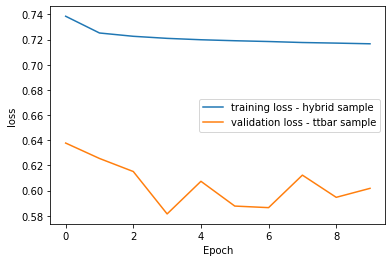

In [16]:
plt.plot(df_results['epoch'],df_results['loss'], label='training loss - hybrid sample')
plt.plot(df_results['epoch'],df_results['val_loss'], label='validation loss - ttbar sample')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

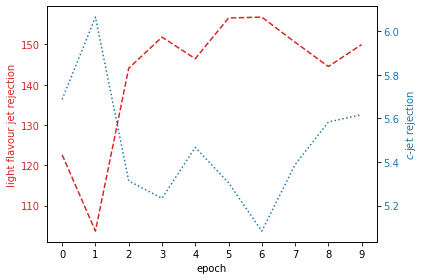

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('light flavour jet rejection', color=color)
ax1.plot(df_results["epoch"],df_results['u_rej'], '--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$c$-jet rejection', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results["epoch"], df_results['c_rej'], ':', color=color, label='std = 0.12')
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()

## Hyper parameter optimisation
You can play with different hyper parameters and see their impact.
The largest impact has the NN-structure itself, you can try changing the number of hidden layers and their number of nodes.
Other hyper parameters are the learning rate, activation function, batch size


## Model Evaluation

In [18]:
b_effs = np.linspace(0.39, 1, 150)
l_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('urej')
c_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('crej')

l_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('urej')
c_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('crej')

In [19]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 50000

MC16d_ttbar-test-validation_sample-NN.h5
1563/1563 [==============================] - 2s 1ms/step
MC16d_Zprime-test-validation_sample-NN.h5
1563/1563 [==============================] - 2s 1ms/step


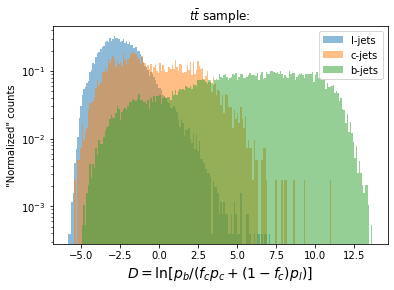

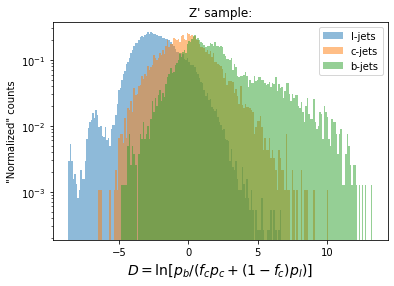

In [29]:
dl1_leffs, dl1_ceffs, dl1_beffs, dl1_discs = [], [], [], []
title_flag = True

for testfile_name in [file_path+"MC16d_ttbar-test-validation_sample-NN.h5",
                      file_path+"MC16d_Zprime-test-validation_sample-NN.h5"]:
    print(testfile_name)
    h5f_test = h5py.File(testfile_name, 'r')

    X_test = h5f_test['X_test'][500000:]
    y_test = h5f_test['Y_test'][500000:]
    
    h5f_test.close()

    (leff, ceff, beff), d = sigBkgEff(model, X_test[:nTest], y_test[:nTest], returnDisc=True, fc=0.018)
    dl1_leffs.append(leff)
    dl1_ceffs.append(ceff)
    dl1_beffs.append(beff)
    dl1_discs.append(d)

    if(title_flag == True):
        plt.title(r'$t\bar{t}$ sample:')
        title_flag = False
    else:
        plt.title('Z\' sample:')

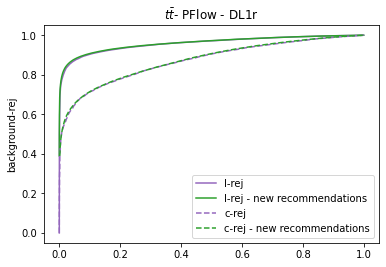

In [33]:
# ttbar
plt.figure()
plt.plot(dl1_leffs[0], dl1_beffs[0], color='C4', label='l-rej')
plt.plot(l_rej, b_effs, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_ceffs[0], dl1_beffs[0], "--", color='C4', label='c-rej')
plt.plot(c_rej, b_effs, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('background-rej')

plt.legend()
plt.title(r'$t\bar{t}$- PFlow - DL1r')
#plt.xscale("log")
#plt.xlim(0.6,1)
#plt.ylim(0,3000) # Changed stuff to draw ROC curves instead...
                  # Can change back... Look at original in repository.

plt.show()

/tmp/ipykernel_3344/4189339395.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dl1_beffs[1], 1 / dl1_leffs[1], color='C4', label='l-rej')
/tmp/ipykernel_3344/4189339395.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dl1_beffs[1], 1 / dl1_ceffs[1],"--", color='C4', label='c-rej')
/tmp/ipykernel_3344/4189339395.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,3000)


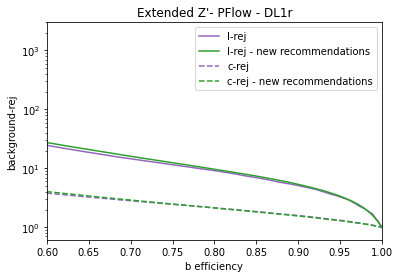

In [22]:
# Z'
plt.figure()
plt.plot(dl1_beffs[1], 1 / dl1_leffs[1], color='C4', label='l-rej')
plt.plot(b_effs, 1./l_rej_Z, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_beffs[1], 1 / dl1_ceffs[1],"--", color='C4', label='c-rej')
plt.plot(b_effs, 1./c_rej_Z, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('background-rej')
plt.xlabel('b efficiency')

plt.legend()
plt.title(r"Extended Z'- PFlow - DL1r")
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,3000)

plt.show()

In [23]:
import numpy as np

In [24]:
a = np.array([[1,2,3],[4,5,6]])
a.shape

(2, 3)

In [25]:
import tensorflow as tf
print(tf.__version__)
import keras as k
print(k.__version__)
import pandas as pd
pd.show_versions()

2.8.0
2.8.0

INSTALLED VERSIONS
------------------
commit           : 4bfe3d07b4858144c219b9346329027024102ab6
python           : 3.8.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.4.0-107-generic
Version          : #121-Ubuntu SMP Thu Mar 24 16:04:27 UTC 2022
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : pt_PT.UTF-8
LOCALE           : pt_PT.UTF-8

pandas           : 1.4.2
numpy            : 1.22.3
pytz             : 2022.1
dateutil         : 2.8.2
pip              : 20.0.2
setuptools       : 44.0.0
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.1
IPython          : 8.2.0
pandas_datareader: None
bs4              : 4.10.0
bottleneck       : None


In [26]:
b_effs = np.linspace(0.39, 1, 150)
l_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('urej')
c_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('crej')

l_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('urej')
c_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('crej')

In [31]:
print(l_rej)

[5.44961633e-05 5.44961633e-05 5.64659041e-05 5.97488055e-05
 6.04053858e-05 6.36882872e-05 6.43448675e-05 6.56580280e-05
 6.69711886e-05 6.95975097e-05 7.28804111e-05 7.48501520e-05
 7.68198928e-05 7.94462139e-05 8.14159548e-05 8.53554365e-05
 8.66685970e-05 9.25778195e-05 9.65173012e-05 1.00456783e-04
 1.03083104e-04 1.07022586e-04 1.10962067e-04 1.14244969e-04
 1.19497611e-04 1.24093673e-04 1.25406834e-04 1.29346315e-04
 1.36568698e-04 1.41821341e-04 1.45760822e-04 1.52326625e-04
 1.57579267e-04 1.66771391e-04 1.70710873e-04 1.79246417e-04
 1.86468800e-04 1.98287245e-04 2.07479369e-04 2.18641233e-04
 2.25863616e-04 2.38338642e-04 2.52783408e-04 2.66571594e-04
 2.82329521e-04 3.01370349e-04 3.20411177e-04 3.37482264e-04
 3.52583611e-04 3.74250760e-04 3.94604749e-04 4.06423194e-04
 4.34656146e-04 4.54353554e-04 4.90465469e-04 5.17385261e-04
 5.42991892e-04 5.72538005e-04 5.96831475e-04 6.29660489e-04
 6.61832923e-04 6.99914579e-04 7.41279137e-04 7.93148979e-04
 8.39109598e-04 8.837570

In [ ]:
def GetRejection_At_X_WP(y_pred, y_true, WP):
    """Calculates the c and light rejection for 77% WP and 0.018 c-fraction."""
    b_index, c_index, u_index = 2, 1, 0
    cfrac = 0.018
    target_beff = WP
    y_true = np.argmax(y_true, axis=1)
    b_jets = y_pred[y_true == b_index]
    c_jets = y_pred[y_true == c_index]
    u_jets = y_pred[y_true == u_index]
    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
                                           (1 - cfrac) * b_jets[:, u_index]))
    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

    c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
                                                    + (1 - cfrac) *
                                                    c_jets[:, u_index])) >
                       cutvalue]) / float(len(c_jets))
    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
                                                    u_jets[:, c_index] +
                                                    (1 - cfrac) *
                                                    u_jets[:, u_index])) >
                       cutvalue]) / float(len(u_jets))

    if c_eff == 0 or u_eff == 0:
        return -1, -1
    return 1. / c_eff, 1. / u_eff

for WP in b_effs:
